# Technical Requirements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')
plt.rc("figure", figsize=(16, 4))

In [2]:
import matplotlib 
import tensorflow as tf

print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
numpy -> {np.__version__}
tensorflow -> {tf.__version__}
''')


Matplotlib -> 3.5.1
pandas -> 1.4.2   
numpy -> 1.22.3
tensorflow -> 2.8.0



In [3]:
path = Path('../../datasets/Ch13/')

In [4]:
# weather = pd.read_csv(path.joinpath('jena_climate_2009_2016.csv.zip'), 
#                       index_col='DateTime', 
#                       usecols=['DateTime','Temperature'], 
#                       parse_dates=True)
# daily_weather = weather.resample('D').mean()

In [5]:
#daily_weather.to_csv(path.joinpath('daily_weather.csv'))

In [6]:
daily_weather = pd.read_csv(path.joinpath('daily_weather.csv'), 
                      index_col='DateTime', 
                      parse_dates=True)

In [7]:
energy = pd.read_csv(path.joinpath('energy_consumption.csv'), 
                     index_col='Month', 
                     parse_dates=True)
energy.columns = ['total_energy']

In [521]:
energy

,total_energy
Month,
1973-01-01,1957.641
1973-02-01,1712.143
1973-03-01,1510.079
1973-04-01,1183.421
1973-05-01,1006.326
...,...
2021-08-01,1755.212
2021-09-01,1456.901
2021-10-01,1315.799


In [8]:
air = pd.read_csv(path.joinpath('air_passenger.csv'), 
                  index_col='date', 
                  parse_dates=True)

## Visualize the time series data

<AxesSubplot:title={'center':'Monthly Passengers'}, xlabel='date'>

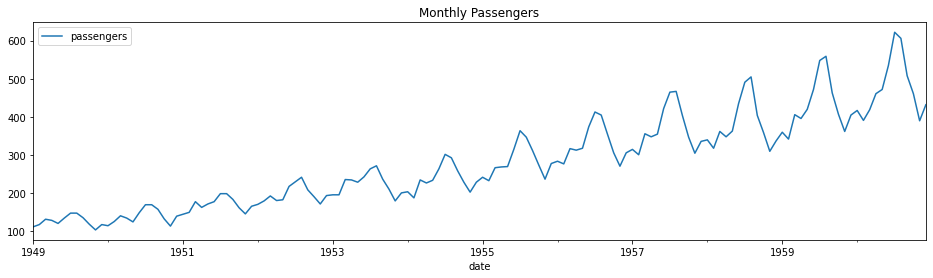

In [9]:
air.plot(title='Monthly Passengers')

<AxesSubplot:title={'center':'Avg Daily Weather Temperature in C'}, xlabel='DateTime'>

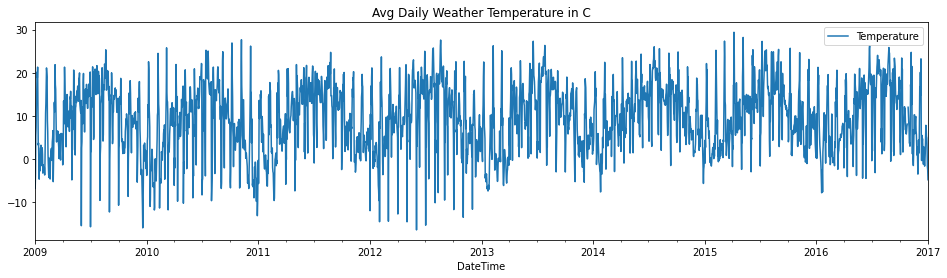

In [10]:
daily_weather.plot(title='Avg Daily Weather Temperature in C')

<AxesSubplot:title={'center':'2012 Avg Daily Weather Temperature Pattern in C'}, xlabel='DateTime'>

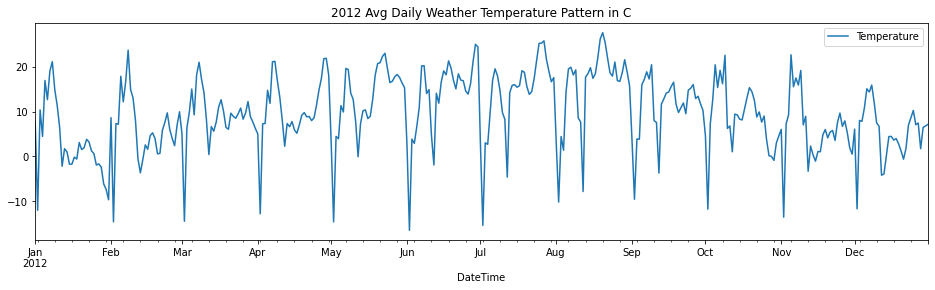

In [11]:
daily_weather.loc['2012'].plot(title='2012 Avg Daily Weather Temperature Pattern in C')

<AxesSubplot:title={'center':'Monthly Energy Consumption'}, xlabel='Month'>

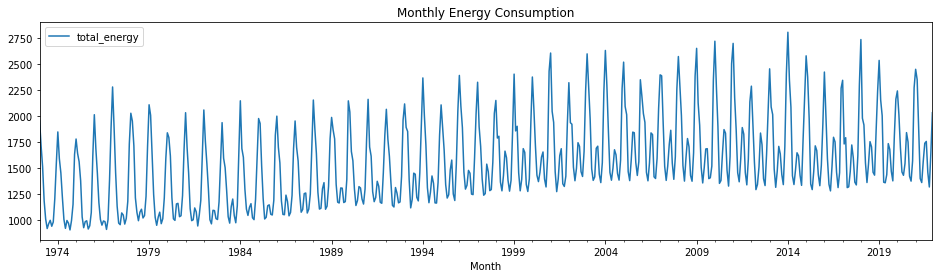

In [12]:
energy.plot(title='Monthly Energy Consumption')

<AxesSubplot:title={'center':'2012-2014 Monthly Energy Consumption Pattern'}, xlabel='Month'>

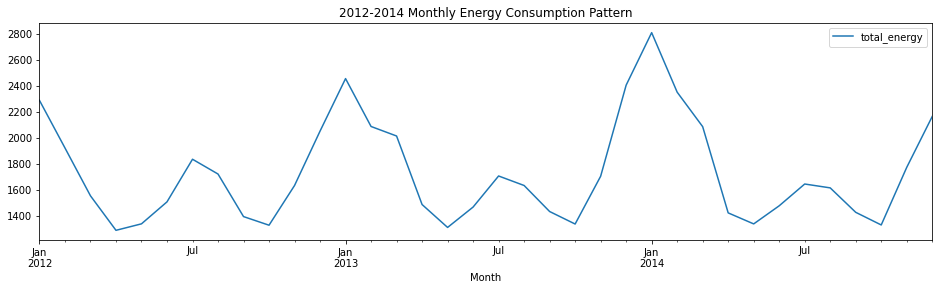

In [13]:
energy.loc['2012':'2014'].plot(title='2012-2014 Monthly Energy Consumption Pattern')

In [14]:
def one_step_sliding_split(df, steps):
    d = df.values
    x, y = [], []
    n = len(df)
    idx = df.index[:-steps]
    for start in range(n-steps):
        end = start + steps
        x.append(d[start:end].ravel())
        y.append(d[end])
    cols = [f'x_{i}' for i in range(1, steps+1)]
    x_df = pd.DataFrame(np.array(x), columns=cols, index=idx)
    y_df = pd.Series(np.array(y).reshape(-1), name='y', index=idx)
    return pd.concat([x_df, y_df], axis=1)

In [15]:
def standardize(train, test):
    mu = train.mean()
    sigma = train.std()
    s_train = (train - mu)/sigma
    s_test = (test - mu)/sigma
    return s_train, s_test

In [16]:
def split_data(df, test_split=0.15):
    n = int(len(df) * test_split)
    train, test = df.iloc[:-n], df.iloc[-n:]
    return train, test


# Forecasting with Keras

In [170]:
from tensorflow.keras import Sequential
from tensorflow import keras
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from keras.layers import (BatchNormalization, Dense,  
                TimeDistributed, Bidirectional, 
                SimpleRNN, GRU, LSTM, Dropout)

In [18]:
def features_target(*args):
    y = [col.pop('y').values.reshape(-1, 1) for col in args]
    x = [col.values.reshape(*col.shape, 1)
                   for col in args]
    return *y, *x

In [430]:
sliding_window = 5
air_d = one_step_sliding_split(air, sliding_window)
dw_d = one_step_sliding_split(daily_weather, sliding_window)
en_d = one_step_sliding_split(energy, sliding_window)

In [431]:
air.head(10)

,passengers
date,
1949-01-31,112
1949-02-28,118
1949-03-31,132
1949-04-30,129
1949-05-31,121
1949-06-30,135
1949-07-31,148
1949-08-31,148
1949-09-30,136


In [432]:
air_d.head()

,x_1,x_2,x_3,x_4,x_5,y
date,,,,,,
1949-01-31,112,118,132,129,121,135
1949-02-28,118,132,129,121,135,148
1949-03-31,132,129,121,135,148,148
1949-04-30,129,121,135,148,148,136
1949-05-31,121,135,148,148,136,119


In [433]:
dw_d.head()

,x_1,x_2,x_3,x_4,x_5,y
DateTime,,,,,,
2009-01-01,-6.810629,-3.360486,5.435694,7.283889,12.690069,15.201597
2009-01-02,-3.360486,5.435694,7.283889,12.690069,15.201597,20.121875
2009-01-03,5.435694,7.283889,12.690069,15.201597,20.121875,18.864792
2009-01-04,7.283889,12.690069,15.201597,20.121875,18.864792,21.289722
2009-01-05,12.690069,15.201597,20.121875,18.864792,21.289722,11.937847


In [434]:
en_d.head()

,x_1,x_2,x_3,x_4,x_5,y
Month,,,,,,
1973-01-01,1957.641,1712.143,1510.079,1183.421,1006.326,914.949
1973-02-01,1712.143,1510.079,1183.421,1006.326,914.949,961.872
1973-03-01,1510.079,1183.421,1006.326,914.949,961.872,994.259
1973-04-01,1183.421,1006.326,914.949,961.872,994.259,937.083
1973-05-01,1006.326,914.949,961.872,994.259,937.083,978.162


In [435]:
train_air, test_air = split_data(air_d)
train_dw, test_dw = split_data(dw_d)
train_en, test_en = split_data(en_d)

print(f'''
air: train: {len(train_air)} , test: {len(test_air)}
weather: train: {len(train_dw)} , test: {len(test_dw)}
energy: train: {len(train_en)} , test: {len(test_en)}
''')


air: train: 119 , test: 20
weather: train: 2481 , test: 437
energy: train: 496 , test: 87



In [436]:
train_air_s, test_air_s = standardize(train_air, test_air)
train_dw_s, test_dw_s = standardize(train_dw, test_dw)
train_en_s, test_en_s = standardize(train_en, test_en)

In [437]:
train_air_s, val_air_s = split_data(train_air_s, 0.10)
train_dw_s, val_dw_s = split_data(train_dw_s, 0.10)
train_en_s, val_en_s = split_data(train_en_s, 0.10)

In [438]:
print(f'''
air: train: {len(train_air_s)} , test: {len(test_air_s)}, val:{len(val_air_s)}
weather: train: {len(train_dw_s)} , test: {len(test_dw_s)}, val:{len(val_dw_s)}
energy: train: {len(train_en_s)} , test: {len(test_en_s)}, val: {len(val_en_s)}
''')


air: train: 108 , test: 20, val:11
weather: train: 2233 , test: 437, val:248
energy: train: 447 , test: 87, val: 49



In [439]:
(y_train_air, 
 y_val_air, 
 y_test_air, 
 x_train_air, 
 x_val_air, 
 x_test_air) = features_target(train_air_s, 
                               val_air_s, 
                               test_air_s)

In [440]:
(y_train_dw, 
y_val_dw, 
y_test_dw, 
x_train_dw, 
x_val_dw, 
x_test_dw) = features_target(train_dw_s, 
                             val_dw_s, 
                             test_dw_s)

In [441]:
(y_train_en, 
y_val_en, 
y_test_en, 
x_train_en, 
x_val_en, 
x_test_en) = features_target(train_en_s, 
                             val_en_s, 
                             test_en_s)

## SimpleRNN

In [499]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(SimpleRNN(units=units,
                        return_sequences=False,
                        input_shape=(train.shape[1], 
                                     train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

In [500]:
def train_model(model, 
                x_train, 
                y_train, 
                x_val, 
                y_val, 
                epochs=100, 
                patience=8, 
                batch_size=32):
    
    model.compile(optimizer='adam', 
                  loss='mean_squared_error', 
                  metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
    
    es = keras.callbacks.EarlyStopping(monitor="val_loss", 
                                       min_delta=0, 
                                       patience=patience)
    
    history = model.fit(x_train,
              y_train, 
              shuffle=False, 
              epochs=epochs,
              batch_size=batch_size, 
              validation_data=(x_val, y_val),
              callbacks=[es],
              verbose=1)
    return history

In [501]:
def plot_forecast(model, x_test, y_test, index, history):
    plt.figure(figsize=(20, 10))
    ax1 = plt.subplot2grid((2, 2), (0, 0))
    pd.Series(history.history['root_mean_squared_error']).plot(ax=ax1, 
                                                               title='RMSE by EPOCH',
                                                              label='rmse')
    pd.Series(history.history['val_root_mean_squared_error']).plot(ax=ax1,
                                                                  label='val_rmse')
    plt.legend()

    ax2 = plt.subplot2grid((2, 2), (0, 1))
    pd.Series(history.history['mean_absolute_error']).plot(ax=ax2,
                                                          title='MAE by EPOCH',
                                                          label='mae')
    pd.Series(history.history['val_mean_absolute_error']).plot(ax=ax2,
                                                              label='val_mae')
    plt.legend()
    ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
    predicted = model.predict(x_test)
    pd.Series(y_test.reshape(-1), 
              index=index).plot(style='k--', alpha=0.5, ax=ax3, 
                                title='Forecast vs Actual',
                               label='actual')
    pd.Series(predicted.reshape(-1), 
              index=index).plot(style='k', label='Forecast', ax=ax3)
    plt.legend();plt.show()


### Air Passenger

In [502]:
model_a_simpleRNN = create_model(train=x_train_air, units=16)

In [503]:
model_a_simpleRNN.summary()

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_18 (SimpleRNN)   (None, 16)                288       
                                                                 
 dropout_44 (Dropout)        (None, 16)                0         
                                                                 
 dense_38 (Dense)            (None, 1)                 17        
                                                                 
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________


In [504]:
history_a_simpleRNN = train_model(model_a_simpleRNN, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/100
4/4 [==============================] - 1s 72ms/step - loss: 1.8588 - root_mean_squared_error: 1.3634 - mean_absolute_error: 1.1508 - val_loss: 4.6294 - val_root_mean_squared_error: 2.1516 - val_mean_absolute_error: 1.9889
Epoch 2/100
4/4 [==============================] - 0s 9ms/step - loss: 1.4831 - root_mean_squared_error: 1.2178 - mean_absolute_error: 1.0227 - val_loss: 4.1960 - val_root_mean_squared_error: 2.0484 - val_mean_absolute_error: 1.8758
Epoch 3/100
4/4 [==============================] - 0s 11ms/step - loss: 1.4445 - root_mean_squared_error: 1.2019 - mean_absolute_error: 0.9867 - val_loss: 3.7894 - val_root_mean_squared_error: 1.9466 - val_mean_absolute_error: 1.7637
Epoch 4/100
4/4 [==============================] - 0s 10ms/step - loss: 1.2164 - root_mean_squared_error: 1.1029 - mean_absolute_error: 0.9098 - val_loss: 3.4099 - val_root_mean_squared_error: 1.8466 - val_mean_absolute_error: 1.6528
Epoch 5/100
4/4 [==============================] - 0s 13ms/step -

In [505]:
history_a_simpleRNN.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_root_mean_squared_error', 'val_mean_absolute_error'])

In [506]:
model_a_simpleRNN.evaluate(x=x_test_air, y=y_test_air)

1/1 [==============================] - 0s 21ms/step - loss: 1.3050 - root_mean_squared_error: 1.1423 - mean_absolute_error: 0.8928


[1.3049519062042236, 1.1423449516296387, 0.8928178548812866]

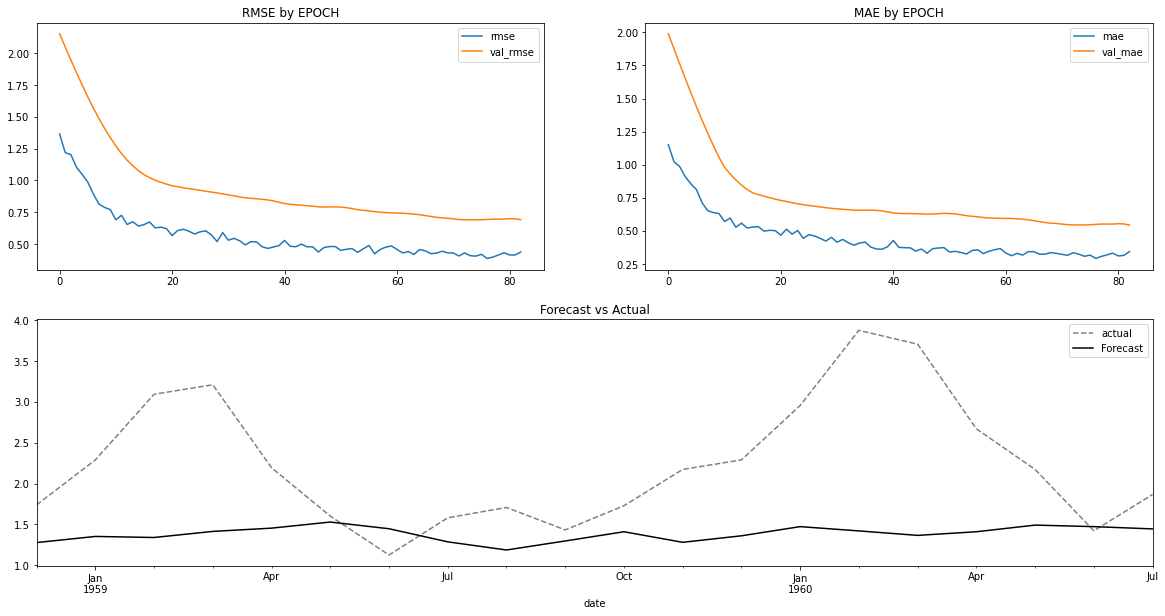

In [507]:
plot_forecast(model_a_simpleRNN, x_test_air, y_test_air, test_air.index, history_a_simpleRNN)

### Avg Daily Temp

In [509]:
model_dw_simpleRNN = create_model(x_train_dw, units=16)

In [510]:
model_dw_simpleRNN.summary()

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_20 (SimpleRNN)   (None, 16)                288       
                                                                 
 dropout_46 (Dropout)        (None, 16)                0         
                                                                 
 dense_40 (Dense)            (None, 1)                 17        
                                                                 
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________


In [511]:
history_dw_simpleRNN = train_model(model_dw_simpleRNN, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)

Epoch 1/100
35/35 [==============================] - 1s 8ms/step - loss: 0.5418 - root_mean_squared_error: 0.7361 - mean_absolute_error: 0.5474 - val_loss: 0.4205 - val_root_mean_squared_error: 0.6485 - val_mean_absolute_error: 0.4952
Epoch 2/100
35/35 [==============================] - 0s 3ms/step - loss: 0.4899 - root_mean_squared_error: 0.6999 - mean_absolute_error: 0.5125 - val_loss: 0.4050 - val_root_mean_squared_error: 0.6364 - val_mean_absolute_error: 0.4810
Epoch 3/100
35/35 [==============================] - 0s 3ms/step - loss: 0.4513 - root_mean_squared_error: 0.6718 - mean_absolute_error: 0.4876 - val_loss: 0.4009 - val_root_mean_squared_error: 0.6332 - val_mean_absolute_error: 0.4745
Epoch 4/100
35/35 [==============================] - 0s 3ms/step - loss: 0.4641 - root_mean_squared_error: 0.6812 - mean_absolute_error: 0.4885 - val_loss: 0.3982 - val_root_mean_squared_error: 0.6310 - val_mean_absolute_error: 0.4724
Epoch 5/100
35/35 [==============================] - 0s 3ms/

In [512]:
model_dw_simpleRNN.evaluate(x=x_test_dw, y=y_test_dw)

14/14 [==============================] - 0s 2ms/step - loss: nan - root_mean_squared_error: nan - mean_absolute_error: nan     


[nan, nan, nan]

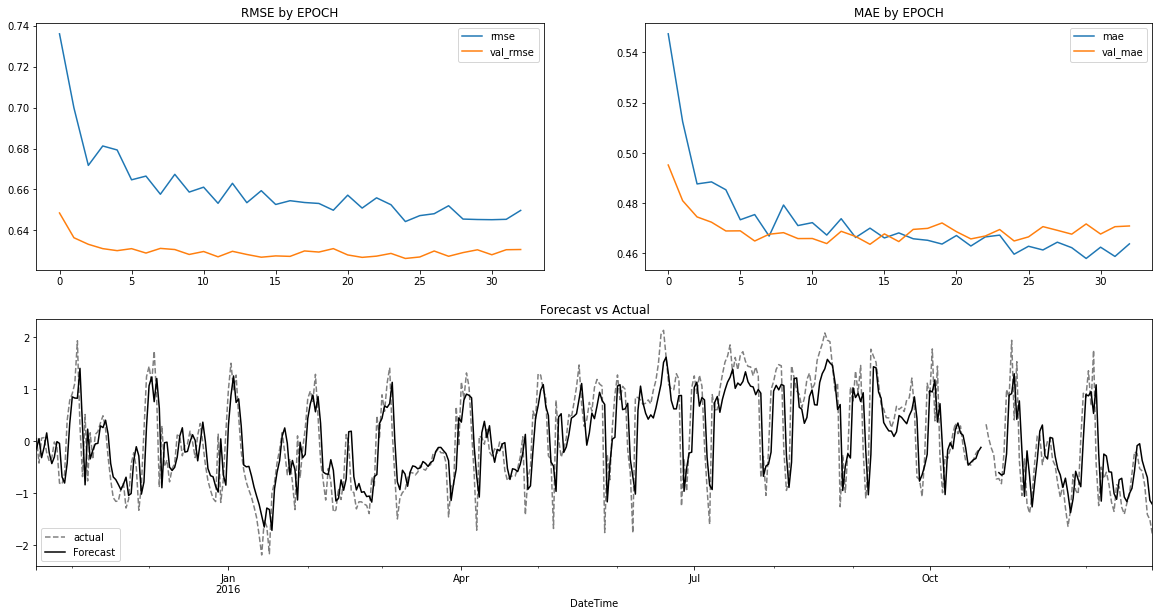

In [513]:
plot_forecast(model_dw_simpleRNN, x_test_dw, y_test_dw, test_dw.index, history_dw_simpleRNN)

### Energy Consumption

In [515]:
model_en_simpleRNN = create_model(x_train_en, units=16)
model_en_simpleRNN.summary()

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_22 (SimpleRNN)   (None, 16)                288       
                                                                 
 dropout_48 (Dropout)        (None, 16)                0         
                                                                 
 dense_42 (Dense)            (None, 1)                 17        
                                                                 
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________


In [516]:
history_en_simpleRNN = train_model(model_en_simpleRNN, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)

Epoch 1/100
7/7 [==============================] - 1s 41ms/step - loss: 0.4802 - root_mean_squared_error: 0.6930 - mean_absolute_error: 0.5616 - val_loss: 0.5472 - val_root_mean_squared_error: 0.7397 - val_mean_absolute_error: 0.5508
Epoch 2/100
7/7 [==============================] - 0s 7ms/step - loss: 0.4291 - root_mean_squared_error: 0.6551 - mean_absolute_error: 0.5252 - val_loss: 0.5477 - val_root_mean_squared_error: 0.7401 - val_mean_absolute_error: 0.5591
Epoch 3/100
7/7 [==============================] - 0s 10ms/step - loss: 0.4163 - root_mean_squared_error: 0.6452 - mean_absolute_error: 0.5137 - val_loss: 0.5339 - val_root_mean_squared_error: 0.7307 - val_mean_absolute_error: 0.5555
Epoch 4/100
7/7 [==============================] - 0s 8ms/step - loss: 0.3987 - root_mean_squared_error: 0.6315 - mean_absolute_error: 0.5061 - val_loss: 0.5156 - val_root_mean_squared_error: 0.7181 - val_mean_absolute_error: 0.5504
Epoch 5/100
7/7 [==============================] - 0s 8ms/step - l

In [517]:
model_en_simpleRNN.evaluate(x=x_test_en, y=y_test_en)

3/3 [==============================] - 0s 3ms/step - loss: 0.2754 - root_mean_squared_error: 0.5248 - mean_absolute_error: 0.4032


[0.27543652057647705, 0.5248204469680786, 0.40321844816207886]

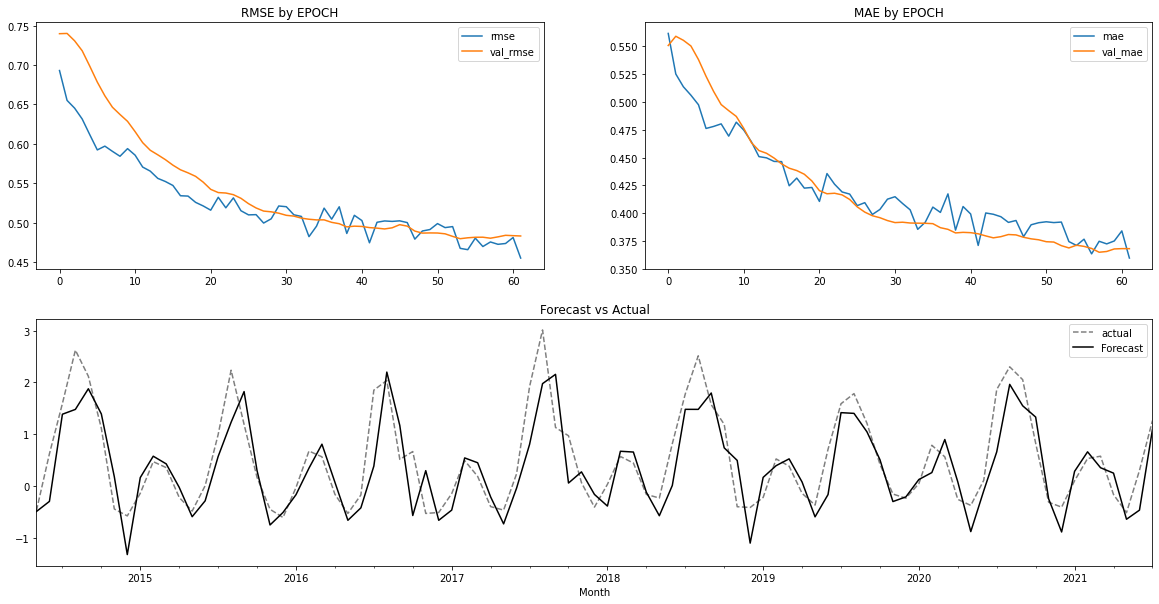

In [518]:
plot_forecast(model_en_simpleRNN, x_test_en, y_test_en, test_en.index, history_en_simpleRNN)

## LSTM

In [380]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units,input_shape=(train.shape[1], train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

### Air Passenger

In [381]:
model_a_lstm = create_model(train=x_train_air, units=32)
model_a_lstm.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 32)                4352      
                                                                 
 dropout_29 (Dropout)        (None, 32)                0         
                                                                 
 dense_24 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [382]:
history_a_lstm = train_model(model_a_lstm, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/100
4/4 [==============================] - 2s 138ms/step - loss: 0.5762 - root_mean_squared_error: 0.7591 - mean_absolute_error: 0.6239 - val_loss: 1.6129 - val_root_mean_squared_error: 1.2700 - val_mean_absolute_error: 1.0806
Epoch 2/100
4/4 [==============================] - 0s 15ms/step - loss: 0.4669 - root_mean_squared_error: 0.6833 - mean_absolute_error: 0.5578 - val_loss: 1.3594 - val_root_mean_squared_error: 1.1659 - val_mean_absolute_error: 0.9542
Epoch 3/100
4/4 [==============================] - 0s 15ms/step - loss: 0.3736 - root_mean_squared_error: 0.6112 - mean_absolute_error: 0.4917 - val_loss: 1.1367 - val_root_mean_squared_error: 1.0661 - val_mean_absolute_error: 0.8451
Epoch 4/100
4/4 [==============================] - 0s 15ms/step - loss: 0.3257 - root_mean_squared_error: 0.5707 - mean_absolute_error: 0.4449 - val_loss: 0.9582 - val_root_mean_squared_error: 0.9789 - val_mean_absolute_error: 0.7419
Epoch 5/100
4/4 [==============================] - 0s 15ms/step

In [384]:
model_a_lstm.evaluate(x=x_test_air, y=y_test_air)

1/1 [==============================] - 0s 20ms/step - loss: 1.9039 - root_mean_squared_error: 1.3798 - mean_absolute_error: 1.1322


[1.9039026498794556, 1.3798197507858276, 1.1322296857833862]

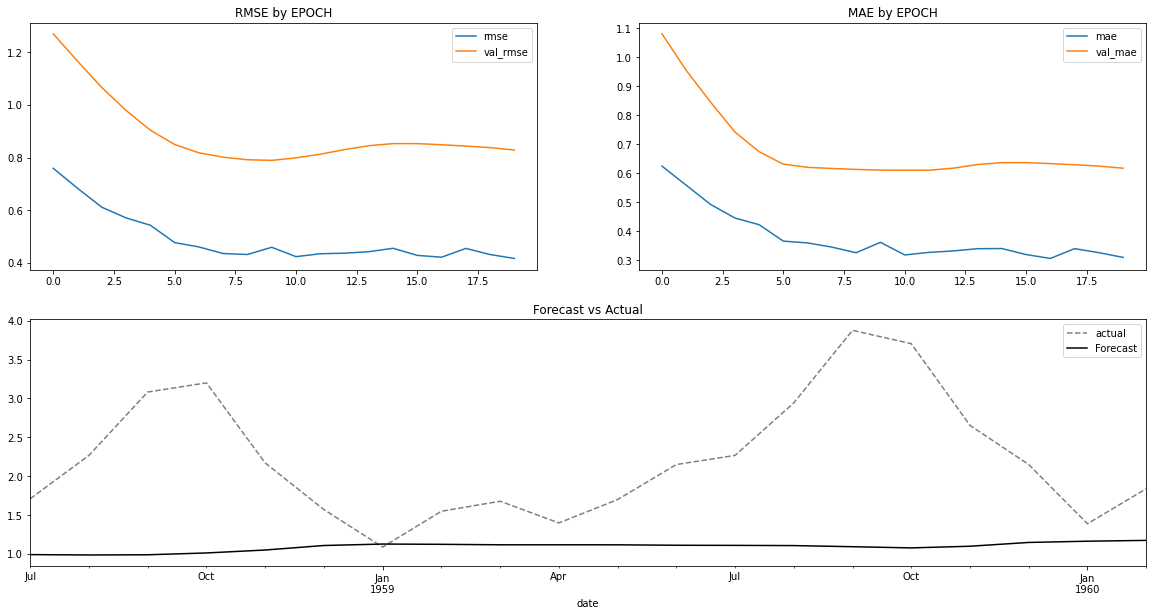

In [385]:
plot_forecast(model_a_lstm, x_test_air, y_test_air, test_air.index, history_a_lstm)

### Avg Daily Temp

In [386]:
model_dw_lstm = create_model(train=x_train_dw, units=32)
model_dw_lstm.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 32)                4352      
                                                                 
 dropout_30 (Dropout)        (None, 32)                0         
                                                                 
 dense_25 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [387]:
history_dw_lstm = train_model(model_dw_lstm, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)

Epoch 1/100
35/35 [==============================] - 2s 18ms/step - loss: 0.8733 - root_mean_squared_error: 0.9345 - mean_absolute_error: 0.7581 - val_loss: 0.6591 - val_root_mean_squared_error: 0.8118 - val_mean_absolute_error: 0.5991
Epoch 2/100
35/35 [==============================] - 0s 6ms/step - loss: 0.7326 - root_mean_squared_error: 0.8559 - mean_absolute_error: 0.6647 - val_loss: 0.5996 - val_root_mean_squared_error: 0.7743 - val_mean_absolute_error: 0.5609
Epoch 3/100
35/35 [==============================] - 0s 7ms/step - loss: 0.6706 - root_mean_squared_error: 0.8189 - mean_absolute_error: 0.6307 - val_loss: 0.5587 - val_root_mean_squared_error: 0.7475 - val_mean_absolute_error: 0.5411
Epoch 4/100
35/35 [==============================] - 0s 7ms/step - loss: 0.6256 - root_mean_squared_error: 0.7909 - mean_absolute_error: 0.6059 - val_loss: 0.5236 - val_root_mean_squared_error: 0.7236 - val_mean_absolute_error: 0.5283
Epoch 5/100
35/35 [==============================] - 0s 8ms

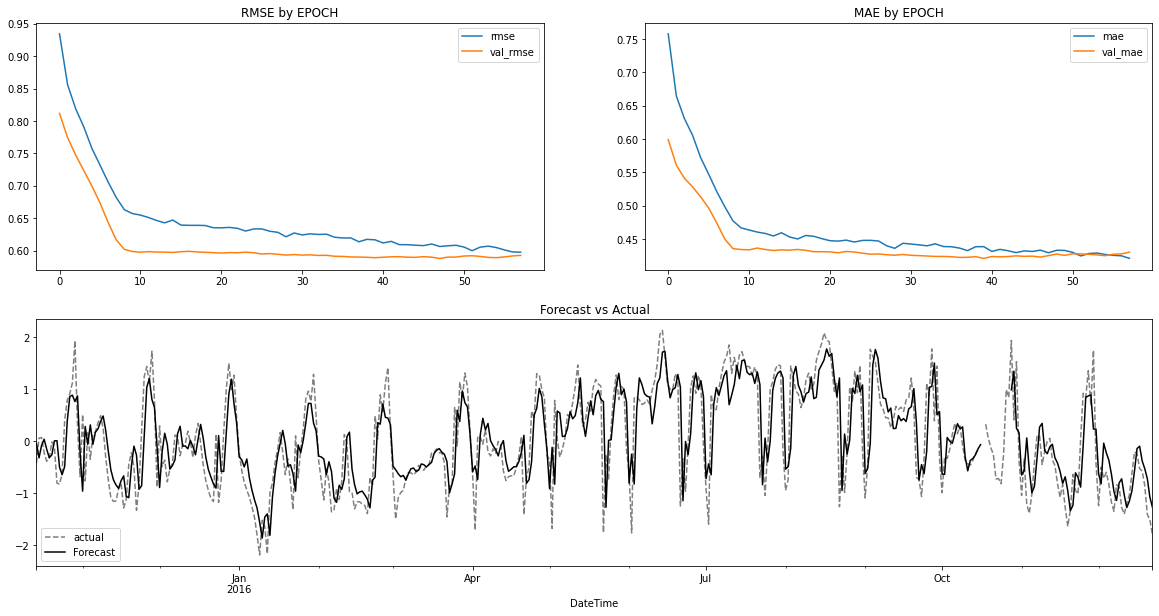

In [390]:
plot_forecast(model_dw_lstm, x_test_dw, y_test_dw, test_dw.index, history_dw_lstm)

### Energy Consumption

In [391]:
model_en_lstm = create_model(train=x_train_en, units=32)
model_en_lstm.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 32)                4352      
                                                                 
 dropout_31 (Dropout)        (None, 32)                0         
                                                                 
 dense_26 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [393]:
history_en_lstm = train_model(model_en_lstm, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)

Epoch 1/100
7/7 [==============================] - 2s 71ms/step - loss: 0.0733 - root_mean_squared_error: 0.2708 - mean_absolute_error: 0.2109 - val_loss: 0.1501 - val_root_mean_squared_error: 0.3874 - val_mean_absolute_error: 0.2821
Epoch 2/100
7/7 [==============================] - 0s 11ms/step - loss: 0.0869 - root_mean_squared_error: 0.2948 - mean_absolute_error: 0.2255 - val_loss: 0.1539 - val_root_mean_squared_error: 0.3923 - val_mean_absolute_error: 0.2848
Epoch 3/100
7/7 [==============================] - 0s 10ms/step - loss: 0.0872 - root_mean_squared_error: 0.2953 - mean_absolute_error: 0.2180 - val_loss: 0.1590 - val_root_mean_squared_error: 0.3987 - val_mean_absolute_error: 0.2826
Epoch 4/100
7/7 [==============================] - 0s 10ms/step - loss: 0.0822 - root_mean_squared_error: 0.2867 - mean_absolute_error: 0.2175 - val_loss: 0.1476 - val_root_mean_squared_error: 0.3842 - val_mean_absolute_error: 0.2755
Epoch 5/100
7/7 [==============================] - 0s 9ms/step -

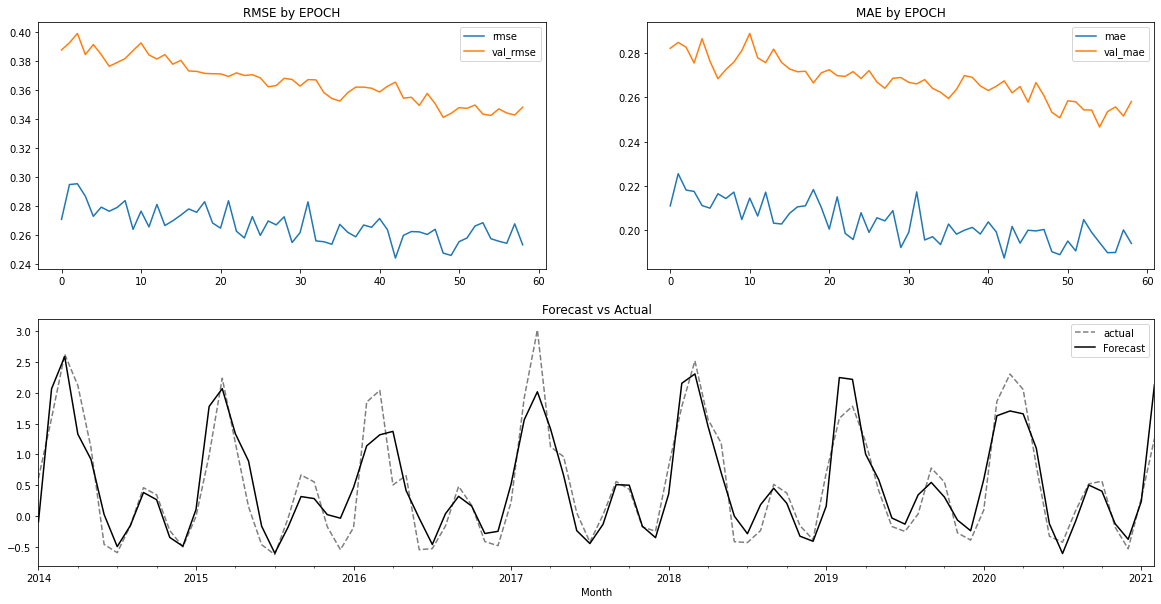

In [394]:
plot_forecast(model_en_lstm, x_test_en, y_test_en, test_en.index, history_en_lstm)

## GRU

In [395]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(GRU(units=units,input_shape=(train.shape[1], train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

### Air Passenger

In [396]:
model_a_gru = create_model(train=x_train_air, units=32)
history_a_gru = train_model(model_a_gru, x_train_air, y_train_air, x_val_air, y_val_air)


Epoch 1/100
4/4 [==============================] - 2s 130ms/step - loss: 1.0437 - root_mean_squared_error: 1.0216 - mean_absolute_error: 0.8688 - val_loss: 2.8762 - val_root_mean_squared_error: 1.6959 - val_mean_absolute_error: 1.5667
Epoch 2/100
4/4 [==============================] - 0s 16ms/step - loss: 0.8759 - root_mean_squared_error: 0.9359 - mean_absolute_error: 0.7991 - val_loss: 2.5542 - val_root_mean_squared_error: 1.5982 - val_mean_absolute_error: 1.4577
Epoch 3/100
4/4 [==============================] - 0s 17ms/step - loss: 0.7691 - root_mean_squared_error: 0.8770 - mean_absolute_error: 0.7381 - val_loss: 2.2527 - val_root_mean_squared_error: 1.5009 - val_mean_absolute_error: 1.3472
Epoch 4/100
4/4 [==============================] - 0s 15ms/step - loss: 0.7089 - root_mean_squared_error: 0.8420 - mean_absolute_error: 0.7057 - val_loss: 1.9770 - val_root_mean_squared_error: 1.4061 - val_mean_absolute_error: 1.2369
Epoch 5/100
4/4 [==============================] - 0s 15ms/step

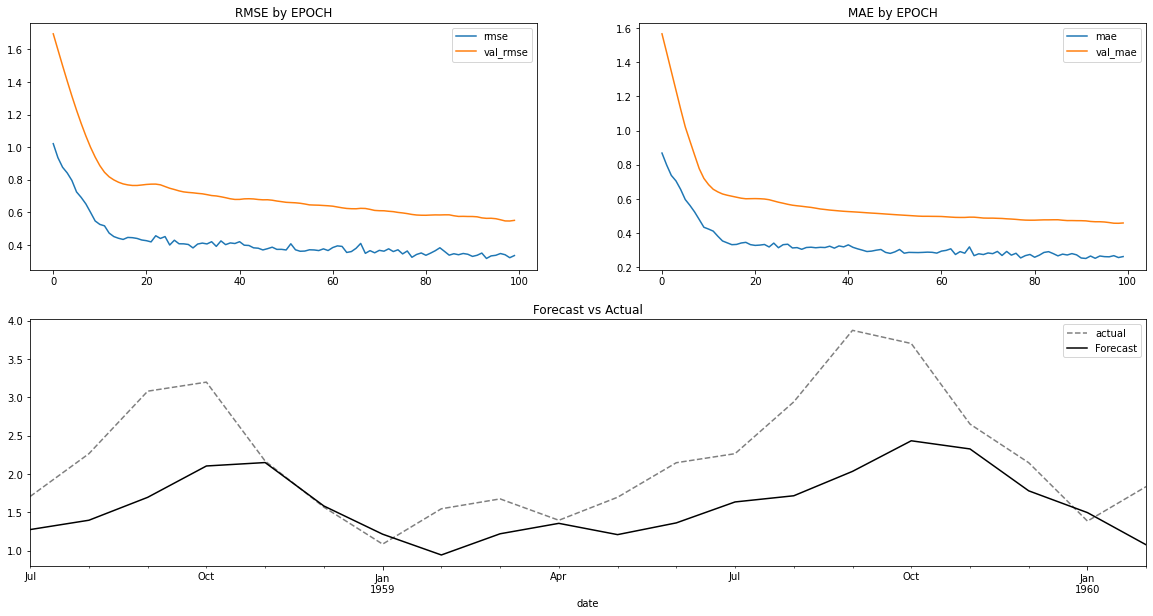

In [398]:
plot_forecast(model_a_gru, x_test_air, y_test_air, test_air.index, history_a_gru)

### Avg Daily Temp

In [399]:
model_dw_gru = create_model(train=x_train_dw, units=32)
history_dw_gru = train_model(model_dw_gru, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)

Epoch 1/100
35/35 [==============================] - 2s 17ms/step - loss: 0.8440 - root_mean_squared_error: 0.9187 - mean_absolute_error: 0.7425 - val_loss: 0.6095 - val_root_mean_squared_error: 0.7807 - val_mean_absolute_error: 0.5789
Epoch 2/100
35/35 [==============================] - 0s 7ms/step - loss: 0.6323 - root_mean_squared_error: 0.7951 - mean_absolute_error: 0.6075 - val_loss: 0.5202 - val_root_mean_squared_error: 0.7213 - val_mean_absolute_error: 0.5250
Epoch 3/100
35/35 [==============================] - 0s 6ms/step - loss: 0.5673 - root_mean_squared_error: 0.7532 - mean_absolute_error: 0.5658 - val_loss: 0.4688 - val_root_mean_squared_error: 0.6847 - val_mean_absolute_error: 0.5017
Epoch 4/100
35/35 [==============================] - 0s 7ms/step - loss: 0.5167 - root_mean_squared_error: 0.7188 - mean_absolute_error: 0.5315 - val_loss: 0.4332 - val_root_mean_squared_error: 0.6582 - val_mean_absolute_error: 0.4852
Epoch 5/100
35/35 [==============================] - 0s 6ms

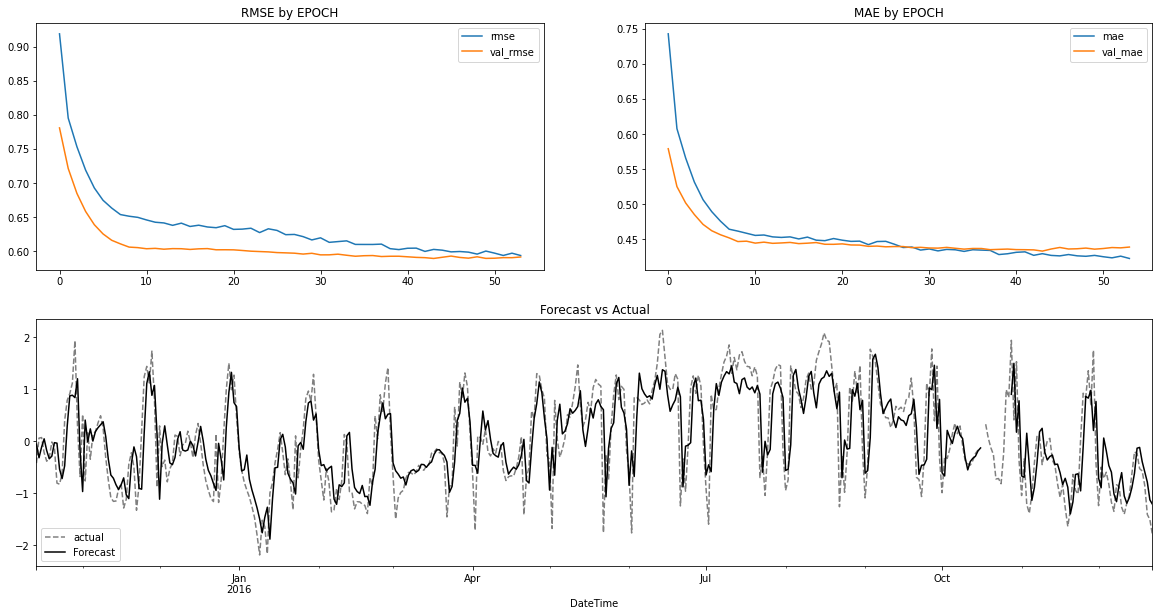

In [401]:
plot_forecast(model_dw_gru, x_test_dw, y_test_dw, test_dw.index, history_dw_gru)

### Energy Consumption

In [402]:
model_en_gru = create_model(x_train_en, units=64)
model_en_gru.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 64)                12864     
                                                                 
 dropout_34 (Dropout)        (None, 64)                0         
                                                                 
 dense_29 (Dense)            (None, 1)                 65        
                                                                 
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________


In [403]:
history_en_gru = train_model(model_en_gru, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)

Epoch 1/100
7/7 [==============================] - 2s 69ms/step - loss: 1.0411 - root_mean_squared_error: 1.0203 - mean_absolute_error: 0.8410 - val_loss: 1.3324 - val_root_mean_squared_error: 1.1543 - val_mean_absolute_error: 0.8336
Epoch 2/100
7/7 [==============================] - 0s 12ms/step - loss: 0.9248 - root_mean_squared_error: 0.9616 - mean_absolute_error: 0.7904 - val_loss: 1.2465 - val_root_mean_squared_error: 1.1165 - val_mean_absolute_error: 0.8189
Epoch 3/100
7/7 [==============================] - 0s 11ms/step - loss: 0.8361 - root_mean_squared_error: 0.9144 - mean_absolute_error: 0.7498 - val_loss: 1.1656 - val_root_mean_squared_error: 1.0796 - val_mean_absolute_error: 0.8008
Epoch 4/100
7/7 [==============================] - 0s 10ms/step - loss: 0.7820 - root_mean_squared_error: 0.8843 - mean_absolute_error: 0.7226 - val_loss: 1.0935 - val_root_mean_squared_error: 1.0457 - val_mean_absolute_error: 0.7800
Epoch 5/100
7/7 [==============================] - 0s 11ms/step 

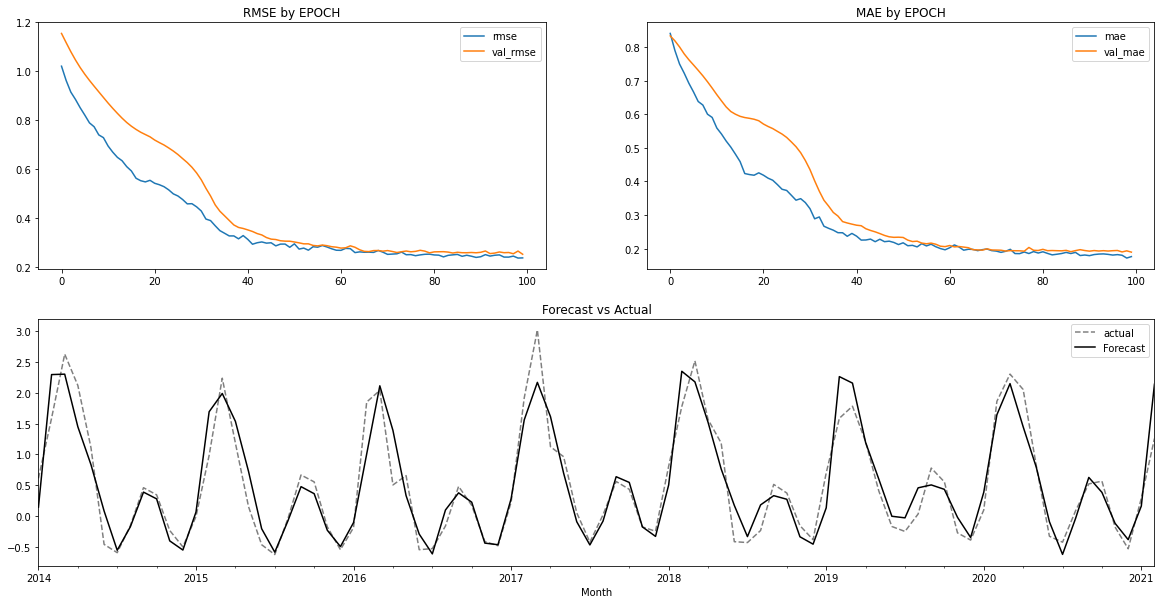

In [405]:
plot_forecast(model_en_gru, x_test_en, y_test_en, test_en.index, history_en_gru)

## Deep RNN-LSTM

### Air Passenger

In [406]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units,input_shape=(train.shape[1], train.shape[2]), return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

In [407]:
model_a_gru = create_model(train=x_train_air, units=32)
history_a_gru = train_model(model_a_gru, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/100
4/4 [==============================] - 3s 235ms/step - loss: 0.8470 - root_mean_squared_error: 0.9203 - mean_absolute_error: 0.7783 - val_loss: 2.1673 - val_root_mean_squared_error: 1.4722 - val_mean_absolute_error: 1.3166
Epoch 2/100
4/4 [==============================] - 0s 22ms/step - loss: 0.6602 - root_mean_squared_error: 0.8126 - mean_absolute_error: 0.6747 - val_loss: 1.7727 - val_root_mean_squared_error: 1.3314 - val_mean_absolute_error: 1.1475
Epoch 3/100
4/4 [==============================] - 0s 20ms/step - loss: 0.5146 - root_mean_squared_error: 0.7173 - mean_absolute_error: 0.5880 - val_loss: 1.4010 - val_root_mean_squared_error: 1.1837 - val_mean_absolute_error: 0.9603
Epoch 4/100
4/4 [==============================] - 0s 18ms/step - loss: 0.4168 - root_mean_squared_error: 0.6456 - mean_absolute_error: 0.5221 - val_loss: 1.0725 - val_root_mean_squared_error: 1.0356 - val_mean_absolute_error: 0.7927
Epoch 5/100
4/4 [==============================] - 0s 25ms/step

In [410]:
model_a_gru.evaluate(x_test_air, y_test_air)

1/1 [==============================] - 0s 35ms/step - loss: 1.7782 - root_mean_squared_error: 1.3335 - mean_absolute_error: 1.0698


[1.7782396078109741, 1.333506464958191, 1.0697667598724365]

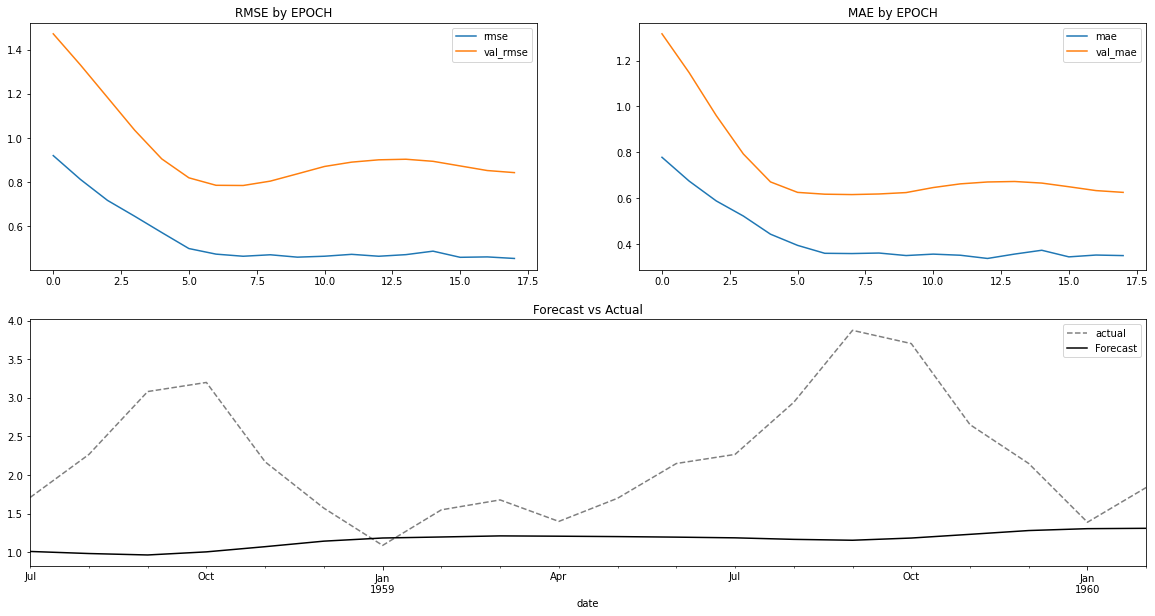

In [409]:
plot_forecast(model_a_gru, x_test_air, y_test_air, test_air.index, history_a_gru)

## Bidirectional

In [411]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(Bidirectional(LSTM(units=units, input_shape=(train.shape[1], train.shape[2]), return_sequences=True)))
    model.add(Dropout(dropout))
    # model.add(TimeDistributed(Dense(1)))
    model.add(Dense(1))
    
    return model

### Air Passenger

In [412]:
model_a_bd = create_model(train=x_train_air, units=32)
history_a_bd = train_model(model_a_bd, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/100
4/4 [==============================] - 4s 231ms/step - loss: 0.8102 - root_mean_squared_error: 0.9001 - mean_absolute_error: 0.7600 - val_loss: 2.2789 - val_root_mean_squared_error: 1.5096 - val_mean_absolute_error: 1.3668
Epoch 2/100
4/4 [==============================] - 0s 16ms/step - loss: 0.7157 - root_mean_squared_error: 0.8460 - mean_absolute_error: 0.7092 - val_loss: 2.0195 - val_root_mean_squared_error: 1.4211 - val_mean_absolute_error: 1.2646
Epoch 3/100
4/4 [==============================] - 0s 18ms/step - loss: 0.6242 - root_mean_squared_error: 0.7901 - mean_absolute_error: 0.6568 - val_loss: 1.7716 - val_root_mean_squared_error: 1.3310 - val_mean_absolute_error: 1.1581
Epoch 4/100
4/4 [==============================] - 0s 17ms/step - loss: 0.5411 - root_mean_squared_error: 0.7356 - mean_absolute_error: 0.6024 - val_loss: 1.5428 - val_root_mean_squared_error: 1.2421 - val_mean_absolute_error: 1.0500
Epoch 5/100
4/4 [==============================] - 0s 16ms/step

In [413]:
model_a_bd.evaluate(x=x_test_air, y=y_test_air)

1/1 [==============================] - 0s 21ms/step - loss: 1.7828 - root_mean_squared_error: 1.3352 - mean_absolute_error: 1.0961


[1.7828058004379272, 1.3352174758911133, 1.0960958003997803]

In [415]:
plot_forecast(model_a_bd, x_test_air, y_test_air, test_air.index, history_a_bd)

## Timedistributed

In [152]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units, input_shape=(train.shape[1], train.shape[2]), return_sequences=True))
    model.add(Dropout(dropout))
    model.add(TimeDistributed(Dense(1)))
    
    return model

### Air Passenger

In [153]:
model_a_td = create_model(train=x_train_air, units=32)
history_a_td = train_model(model_a_td, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/100
4/4 [==============================] - 2s 154ms/step - loss: 0.6915 - val_loss: 1.9515
Epoch 2/100
4/4 [==============================] - 0s 16ms/step - loss: 0.6412 - val_loss: 1.8193
Epoch 3/100
4/4 [==============================] - 0s 15ms/step - loss: 0.5982 - val_loss: 1.6900
Epoch 4/100
4/4 [==============================] - 0s 17ms/step - loss: 0.5537 - val_loss: 1.5668
Epoch 5/100
4/4 [==============================] - 0s 16ms/step - loss: 0.5151 - val_loss: 1.4518
Epoch 6/100
4/4 [==============================] - 0s 15ms/step - loss: 0.4837 - val_loss: 1.3466
Epoch 7/100
4/4 [==============================] - 0s 16ms/step - loss: 0.4468 - val_loss: 1.2530
Epoch 8/100
4/4 [==============================] - 0s 16ms/step - loss: 0.4246 - val_loss: 1.1734
Epoch 9/100
4/4 [==============================] - 0s 14ms/step - loss: 0.4010 - val_loss: 1.1103
Epoch 10/100
4/4 [==============================] - 0s 15ms/step - loss: 0.3805 - val_loss: 1.0641
Epoch 11/100
4/4 [

In [156]:
model_a_td.evaluate(x=x_test_air, y=y_test_air)

1/1 [==============================] - 0s 23ms/step - loss: 2.3324


2.3324482440948486

In [ ]:
plot_forecast(model_a_bd, x_test_air, y_test_air, test_air.index, history_a_bd)

## There is more

Using Keras Model API 

In [157]:
from tensorflow.keras import Model
from tensorflow import keras
from keras.layers import (BatchNormalization, Dense,  
                TimeDistributed, Bidirectional, 
                SimpleRNN, GRU, LSTM, Dropout, Input,
                Activation)

In [160]:
def create_model(train, units, dropout=0.2):
    input_data = Input(shape=(train.shape[1], train.shape[2]))
    simplernn = SimpleRNN(units)(input_data)
    dropout = Dropout(dropout)(simplernn)
    output = Dense(1)(dropout)
    model = Model(inputs=input_data, outputs=output)
    
    return model

### Air Passenger

In [161]:
model_a_m = create_model(train=x_train_air, units=32)
history_a_m = train_model(model_a_m, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/100
4/4 [==============================] - 1s 57ms/step - loss: 2.8689 - val_loss: 5.2118
Epoch 2/100
4/4 [==============================] - 0s 11ms/step - loss: 1.8124 - val_loss: 3.6843
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 1.2714 - val_loss: 2.5532
Epoch 4/100
4/4 [==============================] - 0s 11ms/step - loss: 0.7138 - val_loss: 1.7509
Epoch 5/100
4/4 [==============================] - 0s 12ms/step - loss: 0.5426 - val_loss: 1.1989
Epoch 6/100
4/4 [==============================] - 0s 12ms/step - loss: 0.4262 - val_loss: 0.8449
Epoch 7/100
4/4 [==============================] - 0s 12ms/step - loss: 0.3186 - val_loss: 0.6382
Epoch 8/100
4/4 [==============================] - 0s 11ms/step - loss: 0.2933 - val_loss: 0.5257
Epoch 9/100
4/4 [==============================] - 0s 11ms/step - loss: 0.2854 - val_loss: 0.4726
Epoch 10/100
4/4 [==============================] - 0s 12ms/step - loss: 0.3072 - val_loss: 0.4576
Epoch 11/100
4/4 [=

<AxesSubplot:title={'center':'GRU Air Passenger'}>

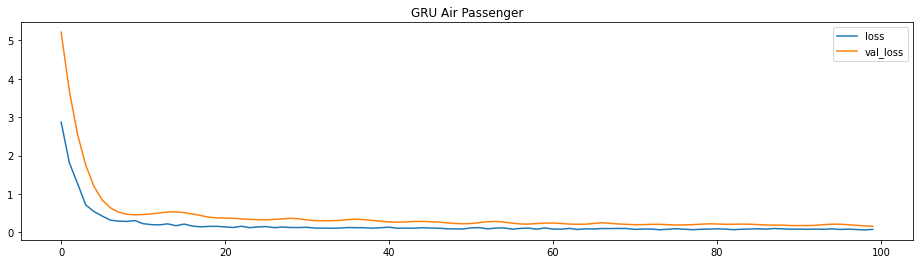

In [162]:
pd.DataFrame(history_a_m.history).plot(title='GRU Air Passenger')

In [163]:
model_a_m.evaluate(x=x_test_air, y=y_test_air)

1/1 [==============================] - 0s 16ms/step - loss: 0.8801


0.8801374435424805

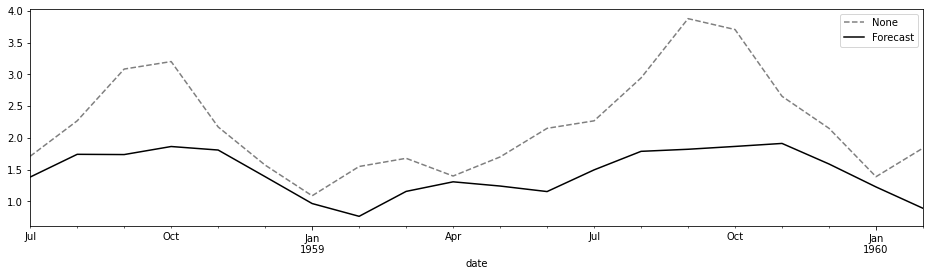

In [164]:
plot_forecast(model_a_m, x_test_air, y_test_air, test_air.index)